# Tutorial 1: Poisson equation

In this tutorial, we will learn

   -  How to solve a simple PDE in Julia with GalerkinToolkit
   -  How to load a discrete model (aka a FE mesh) from a file
   -  How to build a conforming Lagrangian FE space
   -  How to define the different terms in a weak form
   -  How to impose Dirichlet and Neumann boundary conditions
   -  How to visualize results


## Problem statement

In this first tutorial, we provide an overview of a complete simulation pipeline in GalerkinToolkit: from the construction of the FE mesh to the visualization of the computed results. To this end, we consider a simple model problem: the Poisson equation.
 We want to solve the Poisson equation on the 3D domain depicted in next figure with Dirichlet and Neumann boundary conditions. Dirichlet boundary conditions are applied on $\Gamma_{\rm D}$, being the outer sides of the prism (marked in red). Non-homogeneous Neumann conditions are applied to the internal boundaries $\Gamma_{\rm G}$, $\Gamma_{\rm Y}$, and $\Gamma_{\rm B}$ (marked in green, yellow and blue respectively). And homogeneous Neumann boundary conditions are applied in $\Gamma_{\rm W}$, the remaining portion of the boundary (marked in white).

![](../docs/src/assets/poisson/model-r1-2.png)

 Formally, the problem to solve is: find the scalar field $u$ such that

$$
\left\lbrace
\begin{aligned}
-\Delta u = f  \ &\text{in} \ \Omega,\\
u = g \ &\text{on}\ \Gamma_{\rm D},\\
\nabla u\cdot n = h \ &\text{on}\  \Gamma_{\rm N},\\
\end{aligned}
\right.
$$
 being $n$ the outwards unit normal vector to the Neumann boundary $\Gamma_{\rm N} \doteq \Gamma_{\rm G}\cup\Gamma_{\rm Y}\cup\Gamma_{\rm B}\cup\Gamma_{\rm W}$. In this example, we chose $f(x) = 1$, $g(x) = 2$, and $h(x)=3$ on $\Gamma_{\rm G}\cup\Gamma_{\rm Y}\cup\Gamma_{\rm B}$ and $h(x)=0$ on $\Gamma_{\rm W}$. The variable $x$ is the position vector $x=(x_1,x_2,x_3)$.

 ## Numerical scheme

 To solve this PDE, we use a conventional Galerkin finite element (FE) method with conforming Lagrangian FE spaces (see, e.g., [1] for specific details on this formulation). The weak form associated with this formulation is: find $u\in U_g$ such that $ a(u,v) = b(v) $ for all $v\in V_0$, where $U_g$ and $V_0$ are the subset of functions in $H^1(\Omega)$ that fulfill the Dirichlet boundary condition $g$ and $0$ respectively. The bilinear and linear forms for this problems are
$$
  a(u,v) \doteq \int_{\Omega} \nabla v \cdot \nabla u \ {\rm d}\Omega, \quad b(v) \doteq \int_{\Omega} v\ f  \ {\rm  d}\Omega + \int_{\Gamma_{\rm N}} v\ h \ {\rm d}\Gamma_{\rm N}.
$$
The problem is solved numerically by approximating the spaces $U_g$ and $V_0$ by their discrete counterparts associated with a FE mesh of the computational domain $\Omega$. As we have anticipated, we consider standard conforming Lagrangian FE spaces for this purpose.

The implementation of this numerical scheme in GalerkinToolkit is done in a user-friendly way thanks to the abstractions provided by the library. As it will be seen below, all the mathematical objects involved in the definition of the discrete weak problem have a correspondent representation in the code.

 ## Setup

 The step number 0 in order to solve the problem is to load the GalerkinToolkit library in the code. If you have configured your Julia environment properly, it is simply done with the line:

In [10]:
import GalerkinToolkit as GT

using Pkg
Pkg.status()

Project GalerkinToolkit v0.1.0
Status `~/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/HP2SIM/GalerkinToolkit.jl/Project.toml`
  [8e7c35d0] BlockArrays v1.1.1
  [861a8166] Combinatorics v1.0.2
  [442a2c76] FastGaussQuadrature v1.0.2
  [1a297f60] FillArrays v1.13.0
  [f6369f11] ForwardDiff v0.10.36
  [705231aa] Gmsh v0.3.1
  [42fd0dbc] IterativeSolvers v0.9.4
  [da04e1cc] MPI v0.20.22
  [e9d8d322] Metatheory v2.0.2
  [2679e427] Metis v1.5.0
  [5a9dfac6] PartitionedArrays v0.5.5
  [90137ffa] StaticArrays v1.9.7
  [64499a7a] WriteVTK v1.21.0
  [37e2e46d] LinearAlgebra v1.11.0
  [2f01184e] SparseArrays v1.11.0


## Computational mesh

As in any FE simulation, we need a discretization of the computational domain (i.e., a FE mesh). All geometrical data needed for solving a FE problem is provided in GalerkinToolkit by types inheriting from the abstract type `GenericMesh`. In the following line, we build an instance of `GenericMesh` by loading a `msh` file.

In [30]:
mesh = GT.mesh_from_gmsh("../docs/src/assets/model.msh")

Info    : Reading '../docs/src/assets/model.msh'...
Info    : 95 entities
Info    : 7475 nodes
Info    : 40330 elements
Info    : Done reading '../docs/src/assets/model.msh'


GalerkinToolkit.GenericMesh(…)

The file `"model.msh"` (which contains a FE mesh and information about user-defined physical boundaries) was generated by using the [GMSH](http://gmsh.info/) mesh generator. See the documentation of [GMSH](http://gmsh.info/#Documentation).

You can easily inspect the generated discrete model using [Makie](https://docs.makie.org/) and the [GLMakie](https://docs.makie.org/stable/explanations/backends/glmakie#GLMakie) backend. 

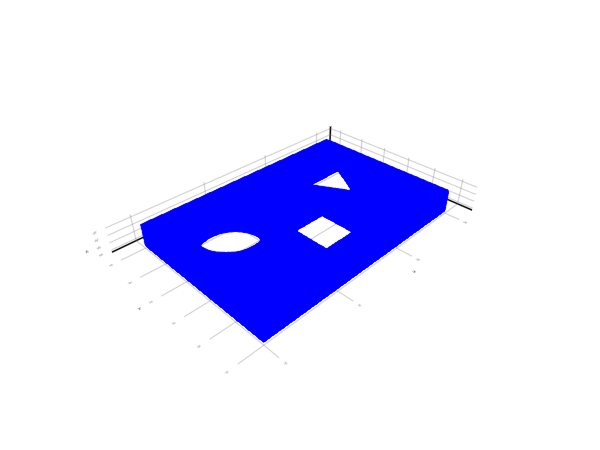

In [66]:
using GLMakie
Makie.inline!(true)

plt = GT.plot(mesh)
Makie.plot(plt;shading=Makie.NoShading,color=:blue)

Alternatively, the generated discrete model can also be viewed using [Paraview](https://www.paraview.org/) by writing it in [WriteVTK](https://github.com/JuliaVTK/WriteVTK.jl) format.

In [74]:
using WriteVTK

plt = GT.plot(mesh)
WriteVTK.vtk_grid("mesh", plt) |> close

1-element Vector{String}:
 "mesh.vtu"

Apart from visualizations, users can additionally inspect general mesh attributes by resorting to several GalerkinToolkit's built-in functions, *e.g*, `num_dims`, `num_nodes`, `num_faces`, `node_coordinates`, `node_coordinates`, `physical_faces`, etc.

In [75]:
GT.physical_faces(mesh,2)

Dict{String, Vector{Int32}} with 6 entries:
  "triangle" => [5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410  … …
  "bottom"   => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  3385, 3386, 3387, 3388, 3389…
  "circle"   => [6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618  … …
  "top"      => [7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062  … …
  "square"   => [6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062  … …
  "sides"    => [3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404  … …

In [76]:
GT.physical_faces(mesh,3)

Dict{String, Vector{Int32}} with 1 entry:
  "volume" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  29151, 29152, 29153, 29154, 29…

## Computational domains

In [77]:
Ω = GT.interior(mesh;physical_names=["volume"])

GalerkinToolkit.PhysicalDomain(…)

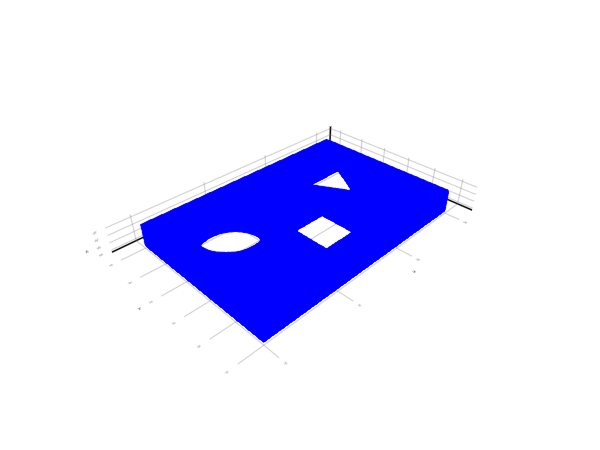

GLMakie.Screen(...)

In [78]:
plt = GT.plot(Ω)
fig = Makie.plot(plt;shading=Makie.NoShading,color=:blue)
display(fig)

In [79]:
Γd = GT.boundary(mesh;physical_names=["sides"])

GalerkinToolkit.PhysicalDomain(…)

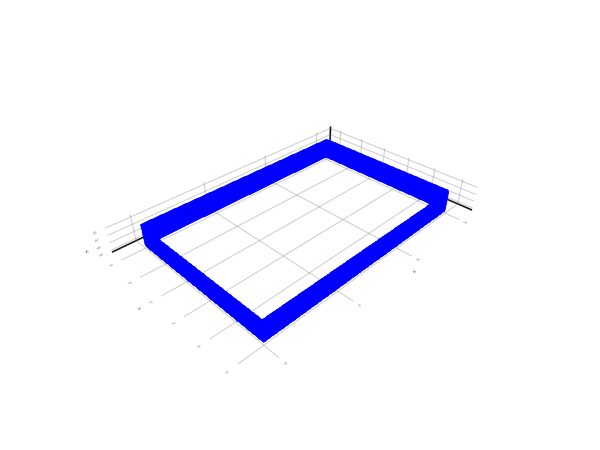

GLMakie.Screen(...)

In [80]:
plt = GT.plot(Γd)
fig = Makie.plot(plt;shading=Makie.NoShading,color=:blue)
display(fig)

In [81]:
Γ = GT.boundary(mesh;physical_names=["circle", "triangle", "square"])

GalerkinToolkit.PhysicalDomain(…)

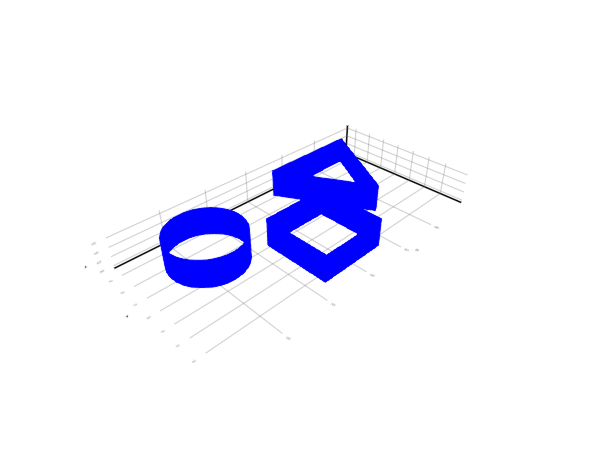

GLMakie.Screen(...)

In [82]:
plt = GT.plot(Γ)
fig = Makie.plot(plt;shading=Makie.NoShading,color=:blue)
display(fig)

The previous line generates four different files `model_0.vtu`, `model_1.vtu`, `model_2.vtu`, and `model_3.vtu` containing the vertices, edges, faces, and cells present in the discrete model. Moreover, you can easily inspect which boundaries are defined within the model.

For instance, if you want to see which faces of the model are on the boundary $\Gamma_{\rm B}$ (i.e., the walls of the circular perforation), open the file `model_2.vtu` and chose coloring by the element field "circle". You should see that only the faces on the circular hole have a value different from zero (see next figure).

![](../docs/src/assets/poisson/fig_faces_on_circle.png)

It is also possible to see which vertices are on the Dirichlet boundary $\Gamma_{\rm D}$. To do so, open the file `model_0.vtu` and chose coloring by the field "sides" (see next figure).

![](../docs/src/assets/poisson/fig_vertices_on_sides.png)

That is, the boundary $\Gamma_{\rm B}$ (i.e., the walls of the circular hole) is called "circle" and the Dirichlet boundary $\Gamma_{\rm D}$ is called "sides" in the model. In addition, the walls of the triangular hole $\Gamma_{\rm G}$ and the walls of the square hole $\Gamma_{\rm Y}$ are identified in the model with the names "triangle" and "square" respectively. You can easily check this by opening the corresponding file in Paraview.


## FE spaces

 Once we have a discretization of the computational domain, the next step is to generate a discrete approximation of the finite element spaces $V_0$ and $U_g$ (i.e. the test and trial FE spaces) of the problem. To do so, first, we are going to build a discretization of $V_0$ as the standard Conforming Lagrangian FE space (with zero boundary conditions) associated with the discretization of the computational domain. The approximation of the FE space $V_0$ is built as follows:

In [86]:
order = 1
V = GT.lagrange_space(Ω,order;dirichlet_boundary=Γd)

GalerkinToolkit.LagrangeSpace(…)

Here, we have used the `TestFESpace` constructor, which constructs a particular FE space (to be used as a test space) from a set of options described as positional and key-word arguments. The first positional argument is the model on top of which we want to build the space. The second positional argument contains information about the type of FE interpolation (the reference FE in this case). With `ReferenceFE(lagrangian,Float64,order)` We select a scalar-valued Lagrangian reference FE of order 1, where the value of the shape functions will be represented with  64-bit floating point numbers. With the key-word argument `conformity` we define the regularity of the interpolation at the boundaries of the cells in the mesh. Here, we use `conformity=:H1`, which means that the resulting interpolation space is a subset of $H^1(\Omega)$ (i.e., continuous shape functions). On the other hand, we pass the identifiers of the Dirichlet boundary via the `dirichlet_tags` argument. In this case, we mark as Dirichlet all objects of the discrete model identified with the `"sides"` tag. Since this is a test space, the corresponding shape functions vanishes at the Dirichlet boundary.

Once the space $V_0$ is discretized in the code, we proceed with the approximation of the trial space $U_g$.

In [85]:
uhd = GT.dirichlet_field(Float64,V)
g = GT.analytical_field(Ω) do x
    2.0
end
GT.interpolate_dirichlet!(g,uhd)

GalerkinToolkit.DiscreteField(…)

In [96]:
WriteVTK.vtk_plot("Γd",Γd) do plt
    GT.plot!(plt,g;label="g")
end
#GT.plot!(plt,g;label="g")
#Makie.plot(plt,color=GT.NodeData("g"))

UndefVarError: UndefVarError: `vtk_plot` not defined in `WriteVTK`
Suggestion: check for spelling errors or missing imports.

In [95]:
WriteVTK.vtk_plot("Ω",Ω) do plt
    GT.plot!(plt,uhd;label="uhd")
end
#GT.plot!(plt,uhd;label="uhd")
#Makie.plot(plt,color=GT.NodeData("uhd"))

UndefVarError: UndefVarError: `vtk_plot` not defined in `GalerkinToolkit`
Suggestion: check for spelling errors or missing imports.

To this end, we have used the `TrialFESpace` constructors. Note that we have passed a function representing the value of the Dirichlet boundary condition, when building the trial space.


## Numerical integration

Once we have built the interpolation spaces, the next step is to set up the machinery to perform the integrals in the weak form numerically. Here, we need to compute integrals on the interior of the domain $\Omega$ and on the Neumann boundary $\Gamma_{\rm N}$. In both cases, we need two main ingredients. We need to define an integration mesh (i.e. a triangulation of the integration domain), plus a Gauss-like quadrature in each of the cells in the triangulation. In Gridap, integration meshes are represented by types inheriting from the abstract type `Triangulation`. For integrating on the domain $\Omega$, we build the following triangulation and the corresponding Lebesgue measure, which will allow to write down integrals in a syntax similar to the usual mathematical notation.

In [18]:
degree = 2*order
dΩ = GT.measure(Ω,degree) # TODO fix pretty printing in GalerkinToolkit.Measure

GalerkinToolkit.Measure(…)

Here, we build a triangulation from the cells of the model and build (an approximation of) the Lebesgue measure using a quadrature rule of degree 2 in the cells of this triangulation. This is enough for integrating the corresponding terms of the weak form exactly for an interpolation of order 1.

On the other hand, we need a special type of triangulation, represented by the type `BoundaryTriangulation`, to integrate on the boundary. Essentially, a `BoundaryTriangulation` is a particular type of `Triangulation` that is aware of which cells in the model are touched by faces on the boundary. We build an instance of this type from the discrete model and the names used to identify the Neumann boundary as follows:

In [19]:
dΓ = GT.measure(Γ,degree)

GalerkinToolkit.Measure(…)

## Differential operators

In [20]:
using ForwardDiff
gradient(u) = x->ForwardDiff.gradient(u,x)
∇(u,x) = GT.call(gradient,u)(x)

∇ (generic function with 1 method)

In addition, we have created a quadrature of degree 2 on top of the cells in the triangulation for the Neumann boundary.

## Weak form

With all the ingredients presented so far, we are ready to define the weak form. This is done by defining functions representing the bi-linear and linear forms:

In [21]:
using LinearAlgebra
f = GT.analytical_field(Ω) do x
    1.0
end
h = GT.analytical_field(Ω) do x
    3.0
end
a(u,v) = GT.∫( x->∇(u,x)⋅∇(v,x), dΩ)
l(v) = GT.∫( x->v(x)*f(x), dΩ) + GT.∫( x->v(x)*h(x),dΓ)

l (generic function with 1 method)

Note that by using the integral function `∫`, the Lebesgue measures `dΩ`, `dΓ`, and the gradient function `∇`, the weak form is written with an obvious relation with the corresponding mathematical notation.

 ## FE Problem

 At this point, we can build the FE problem that, once solved, will provide the numerical solution we are looking for. A FE problem is represented in Gridap by types inheriting from the abstract type `FEOperator` (both for linear and nonlinear cases). Since we want to solve a linear problem, we use the concrete type `AffineFEOperator`, i.e., a problem represented by a matrix and a right hand side vector.

In [22]:
x,A,b = GT.linear_problem(uhd,a,l)

([5.2150170844097e-310, 2.787823149e-314, 2.787823149e-314, 8.487983168e-314, 2.121995792e-314, 5.2150256584581e-310, NaN, NaN, 5.2150170844097e-310, 2.121995791e-314  …  NaN, NaN, NaN, 2.8843385805e-314, NaN, 3.141768011e-314, NaN, 2.8834005396e-314, NaN, 2.8843373987e-314], sparse([1, 22, 74, 289, 337, 338, 339, 340, 341, 1872  …  6303, 335, 465, 467, 468, 1806, 6201, 6224, 6232, 6304], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  6303, 6304, 6304, 6304, 6304, 6304, 6304, 6304, 6304, 6304], [0.06443080405538211, -0.0011816946972152084, -0.0019141180663583925, -0.03255921926190384, -0.013954244941888471, -0.009620087896820673, -0.0021278804315064915, -0.004654033162377993, -0.005173786773138719, 0.003329780400807812  …  0.21999530084991323, -0.015615599976174236, 0.003972555304119093, -0.009088995023018824, -0.00030902681072076353, -0.013784861561036393, -0.014076977113079436, -0.024457375688586837, -0.013734513123868308, 0.17287503833373258], 6304, 6304), [0.001567735161920194, 0.00152075658761

Note that the `AffineFEOperator` object representing our FE problem is built from the function `a` and `b` representing the weak form and test and trial FE spaces `V0` and `Ug`.

 ## Solver phase

 We have constructed a FE problem, the last step is to solve it. In Gridap, FE problems are solved with types inheriting from the abstract type `FESolver`. Since this is a linear problem, we use a `LinearFESolver`:

In [23]:
x .= A\b

6304-element Vector{Float64}:
 2.288817650800605
 3.191214461559075
 3.243769827996373
 4.513021960049178
 4.137978510723658
 2.6511832145611978
 3.9985286410715637
 2.3676403246611577
 2.6253865316943625
 3.1924629585377917
 2.2896951265865444
 3.1863629312428015
 3.2445741024920083
 ⋮
 4.285487712910332
 2.9668852150686487
 2.020241401823711
 2.3980575528123094
 3.9912082231886825
 3.6282800936694914
 3.817091127051113
 2.0771951682489314
 2.0995109886643184
 2.4363879401098405
 4.398698443572705
 2.0089547066118425

 `LinearFESolver` objects are built from a given algebraic linear solver. In this case, we use a LU factorization. Now we are ready to solve the FE problem with the FE solver as follows:

In [24]:
uh = GT.solution_field(uhd,x)

GalerkinToolkit.DiscreteField(…)

The `solve` function returns the computed numerical solution `uh`. This object is an instance of `FEFunction`, the type used to represent a function in a FE space. We can inspect the result by writing it into a `vtk` file:

In [25]:
GT.vtk_plot("Ω",Ω) do plt
    GT.plot!(plt,uhd;label="uhd")
    GT.plot!(plt,uh;label="uh")
end

1-element Vector{String}:
 "Ω.vtu"

 which will generate a file named `results.vtu` having a nodal field named `"uh"` containing the solution of our problem (see next figure).

![](../docs/src/assets/poisson/fig_uh.png)

## References

[1] C. Johnson. *Numerical Solution of Partial Differential Equations by the Finite Element Method*. Dover Publications, 2009.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*